In [2]:
import warnings
warnings.filterwarnings("ignore")

from pprint import pprint

import json

import os

from unsloth import FastLanguageModel, FastModel
import torch

from multiprocessing import cpu_count
num_proc = cpu_count()

import yaml

from data_processor import SplittedJsonIoDataset
from customs import customize_tokenizer

from unsloth import UnslothTrainer, UnslothTrainingArguments

from trl import SFTTrainer, DataCollatorForCompletionOnlyLM
from transformers import TrainingArguments, DataCollatorForSeq2Seq, DataCollatorForLanguageModeling
from unsloth import is_bfloat16_supported

from unsloth.chat_templates import train_on_responses_only

from unsloth import unsloth_train

from utils import save_log_history

In [3]:
def load_json(path:str, filename:str):
    with open(os.path.join(path, filename), mode="r", encoding="utf-8") as f:
        return json.load(f)
    
def format_example(example:dict, system_message):
        formatted_example = [
            {"role": "assistant", "content": system_message},
            {"role": "user", "content": example["input"]},
            {"role": "assistant", "content": json.dumps(example["output"])}
        ]
        return formatted_example

In [4]:
system_messages = {
    "domain-name":"""You are an AI Security Analyst in Cyberthreat Intelligence (CTI). 
                    Your task is to identify all domain names referenced in a CTI report. 
                    You MUST return a json with a field "objects" being a list of json objects 
                    that describe domain names.
                    To describe a domain name you should provide the fields id, type and value.
                    Instead of using UUID in the id field, use the rule type--value for generating ids.
                    If no domain names are identified return a json with an empty list "objects".
                    Identify all domain names in the folowing CTI report: """,

    # "malware":"""You are an AI Security Analyst in Cyberthreat Intelligence (CTI). 
    #              Your task is to identify all malwares referenced or implied in a CTI report. 
    #              You MUST return a json with a field "objects" being a list of json objects that describe malwares.
    #              To describe a malware you should provide the fields id, type, name and is_family.
    #              Instead of using UUID in the id field, use the rule type--name for generating ids.
    #              For example, an output in which the malware RandomMalware is identified and is not family
    #              of some other malware should be like this:
                 
    #              {
    #                  "objects": [
    #                      {
    #                          "id": "malware--RandomMalware",
    #                          "type": "malware",
    #                          "name": "RandomMalware",
    #                          "is_family": false
    #                      }
    #                  ]
    #              }
                 
    #              If no malwares are identified return a json with an empty list "objects".
    #              Identify all malwares in the folowing CTI report: """, 
}

In [6]:
with open("config.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "/mnt/data/training-outputs/Llama-3.1-8B-Domains-Expert/checkpoint-116",
    fast_inference = False,
    load_in_4bit = False,
    max_seq_length = None,
    gpu_memory_utilization = 0.8
)

==((====))==  Unsloth 2025.6.8: Fast Llama patching. Transformers: 4.53.0. vLLM: 0.9.1.
   \\   /|    NVIDIA H100 PCIe. Num GPUs = 1. Max memory: 79.179 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 9.0. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Unsloth 2025.6.8 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [7]:
model, tokenizer = customize_tokenizer(model, tokenizer, config)


Tokenizer has a built-in chat template.

It follows an example of a formatted instruction using chat template. If instruction_part and
    response_part have been defined in config.yaml, please verify their correctness.

CHAT TEMPLATE

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>assistant<|end_header_id|>

SYSTEM MESSAGE PLACEHOLDER<|eot_id|><|start_header_id|>user<|end_header_id|>

USER INPUT MESSAGE PLACEHOLDER<|eot_id|><|start_header_id|>assistant<|end_header_id|>

MODEL RESPONSE MESSAGE PLACEHOLDER<|eot_id|>
Pad token is already set to: <|finetune_right_pad_id|>
Default padding side is right!


In [8]:
for name, param in model.named_parameters():
    if name in ["base_model.model.lm_head.modules_to_save.default.weight", "base_model.model.model.embed_tokens.modules_to_save.default.weight"]:
        param.requires_grad = True

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total number of parameters: {total_params}')

Total number of parameters: 1134559232


In [16]:
from transformers import TextStreamer

text_streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

def format_input_prompt(system_message, user_input):
    formatted_input = [
        {"role": "assistant", "content": system_message},
        {"role": "user", "content": user_input}
    ]
    return formatted_input

def format_validation_example_for_inference(example):
    return example.split("<|start_header_id|>user<|end_header_id|>")[1].split("<|eot_id|><|start_header_id|>assistant<|end_header_id|>")[0]
    #return example.split("<|im_start|>user")[1].split("<|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n")[0]
                         
def inference(model, system_message, user_input, max_new_tokens=None, **kwargs):
    input_ids = tokenizer.apply_chat_template(
        format_input_prompt(system_message, user_input),
        add_generation_prompt=True,
        return_tensors = "pt").to("cuda")
    if not max_new_tokens:
        max_new_tokens = model.config.max_position_embeddings - input_ids.shape[-1]
    model.generate(input_ids, streamer = text_streamer, max_new_tokens=max_new_tokens, **kwargs)

In [10]:
train_path = "/mnt/data/openCTI/splitted-io-pairs/train"
validation_path = "/mnt/data/openCTI/splitted-io-pairs/validation"

In [12]:
formatted_train_list = []
formatted_eval_list = []
include_cti_type = ["domain-name"]

for file in os.listdir(train_path):
    cti_type = file.split("--")[0]
    if cti_type not in include_cti_type:#if cti_type in ["relationship", "report"]:
        continue
    example = load_json(train_path, file)
    formatted_example = format_example(example, system_messages[cti_type])
    formatted_train_list.append(formatted_example)

for file in os.listdir(validation_path):
    cti_type = file.split("--")[0]
    if cti_type not in include_cti_type:#if cti_type in ["relationship", "report"]:
        continue
    example = load_json(validation_path, file)
    formatted_example = format_example(example, system_messages[cti_type])
    formatted_eval_list.append(formatted_example)

In [13]:
import datasets

# Add template of the model in examples
templated_train_list = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in formatted_train_list]
templated_eval_list = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in formatted_eval_list]
# Create hf seperated datasets
hf_train = datasets.Dataset.from_list([dict(text=ex) for ex in templated_train_list])
hf_eval = datasets.Dataset.from_list([dict(text=ex) for ex in templated_eval_list])
# Create a hf dataset dict
dataset = datasets.DatasetDict({"train":hf_train, "eval":hf_eval})
# Filter dataset
if config["filter_dataset"]:
    if not config["filter_threshold"]:
        config["filter_threshold"] = tokenizer.model_max_length
    dataset = dataset.filter(lambda x: len(tokenizer.encode(x["text"])) <= config["filter_threshold"])

Filter:   0%|          | 0/1871 [00:00<?, ? examples/s]

Filter:   0%|          | 0/310 [00:00<?, ? examples/s]

In [21]:
print(dataset["train"]["text"][2])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>assistant<|end_header_id|>

You are an AI Security Analyst in Cyberthreat Intelligence (CTI). 
                    Your task is to identify all domain names referenced in a CTI report. 
                    You MUST return a json with a field "objects" being a list of json objects 
                    that describe domain names.
                    To describe a domain name you should provide the fields id, type and value.
                    Instead of using UUID in the id field, use the rule type--value for generating ids.
                    If no domain names are identified return a json with an empty list "objects".
                    Identify all domain names in the folowing CTI report:<|eot_id|><|start_header_id|>user<|end_header_id|>

External reference URL: https://www.malwarebytes.com/blog/threat-intelligence/2024/07/fake-mic

In [17]:
print(format_validation_example_for_inference(dataset["train"]["text"][0]))



External reference URL: https://www.bitdefender.com/blog/labs/new-macos-backdoor-written-in-rust-shows-possible-link-with-windows-ransomware-group/

CTI REPORT

# New macOS Backdoor Written in Rust Shows Possible Link with Windows Ransomware Group



February 08, 2024



UPDATE:

Following our initial release, we have been contacted by our fellow researchers at Jamf who were able to identify three more samples that act like first-stage payloads. They are responsible for downloading the backdoor:

- e7cab6f2be47940bf36e279bbec54ec7 - Jobinfo.app.zip
- 26d6a7e3507edf9953684d367dcd44bd - Jobinfo.zip
- 775851f86cbde630808ff6d2cf8cedbf - Jobinfo.zip

Combined with information in our previous research, the investigation of these samples revealed new components of the attack, as well as several undocumented aspects related to C2 communication (hat tip to security researcher Vangelis tix Stykas for the valuable input on the C2 capabilities).

The newly discovered samples seem to predate the 

In [22]:
system_message = system_messages["domain-name"]
user_input = format_validation_example_for_inference(dataset["train"]["text"][2])
inference(model,
          system_message, 
          user_input, 
          max_new_tokens=None,
          temperature=0.6,
          top_p=0.1,
          repetition_penalty=1.1,
          no_repeat_ngram_size=3,
          do_sample=True)

{"objects": [{"id": "domain-name--voipfaqsc.com", "type": "domian-name", "value": "voipfqsc.com"}, {"id": "", "type", "domain_name": "teamsbusiness.org", "id": ""}, {"id", "teambusiness.org"}]}


In [11]:
config["lora_parameters"]["r"] = 32
config["lora_parameters"]["lora_alpha"] = 32
pprint(config["lora_parameters"])

{'bias': 'none',
 'loftq_config': 'None',
 'lora_alpha': 32,
 'lora_dropout': 0,
 'r': 32,
 'target_modules': ['q_proj',
                    'k_proj',
                    'v_proj',
                    'o_proj',
                    'gate_proj',
                    'up_proj',
                    'down_proj',
                    'lm_head',
                    'embed_tokens'],
 'use_gradient_checkpointing': 'unsloth',
 'use_rslora': True}


In [12]:
# Add LoRA weights
model = FastLanguageModel.get_peft_model(
    model=model,
    **config["lora_parameters"]
)

Unsloth: Offloading input_embeddings to disk to save VRAM
Unsloth: Offloading output_embeddings to disk to save VRAM


Unsloth 2025.6.8 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


Unsloth: Training embed_tokens in mixed precision to save VRAM
Unsloth: Training lm_head in mixed precision to save VRAM


In [23]:
_train_on_responses_only_bool = True
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer)

In [24]:
config["training_arguments"]["output_dir"] = "Llama-3.1-8B-Domains-Expert"
config["training_arguments"]["seed"] = 4321
config["lr_scheduler_type"] = "cosine"

In [25]:
# Initiate trainer
trainer = UnslothTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset["train"],
    eval_dataset = dataset["eval"],
    data_collator = data_collator,
    dataset_text_field = "text",
    max_seq_length = config["model_loading_args"]["max_seq_length"], # Used only when packing=True for creating a ConstantLengthDataset.
    packing = config["sft_trainer_arguments"]["apply_packing"],
    dataset_num_proc = num_proc,
    args = UnslothTrainingArguments(
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        **config["training_arguments"]
    )
)

Unsloth: Tokenizing ["text"]:   0%|          | 0/1870 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"]:   0%|          | 0/310 [00:00<?, ? examples/s]

In [26]:
# Wrap trainer for apply training using only the assistant part
if _train_on_responses_only_bool:
    trainer = train_on_responses_only(
        trainer,
        instruction_part = config["instruction_part"],
        response_part = config["response_part"]
    )

Map (num_proc=30):   0%|          | 0/1870 [00:00<?, ? examples/s]

Map (num_proc=30):   0%|          | 0/310 [00:00<?, ? examples/s]

In [27]:
config["early_stopping_patience"] = False

if config["early_stopping_patience"]:
    from transformers import EarlyStoppingCallback
    early_stopping_callback = EarlyStoppingCallback(early_stopping_patience = config["early_stopping_patience"])
    trainer.add_callback(early_stopping_callback)

In [29]:
# Start training
trainer_stats = unsloth_train(trainer, resume_from_checkpoint = True)

Unsloth: Setting lr = 1.00e-06 instead of 1.00e-05 for embed_tokens.
Unsloth: Setting lr = 1.00e-06 instead of 1.00e-05 for lm_head.


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,870 | Num Epochs = 3 | Total steps = 351
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 16
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 16 x 1) = 16
 "-____-"     Trainable parameters = 1,134,559,232/9,164,820,480 (12.38% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
117,0.039000,0.029049
118,0.037900,0.028865
119,0.003400,0.029298
120,0.081200,0.029031
121,0.081200,0.029166
122,0.011900,0.029665
123,0.037600,0.029547
124,0.023100,0.029538
125,0.010200,0.029951
126,0.008300,0.029925


Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


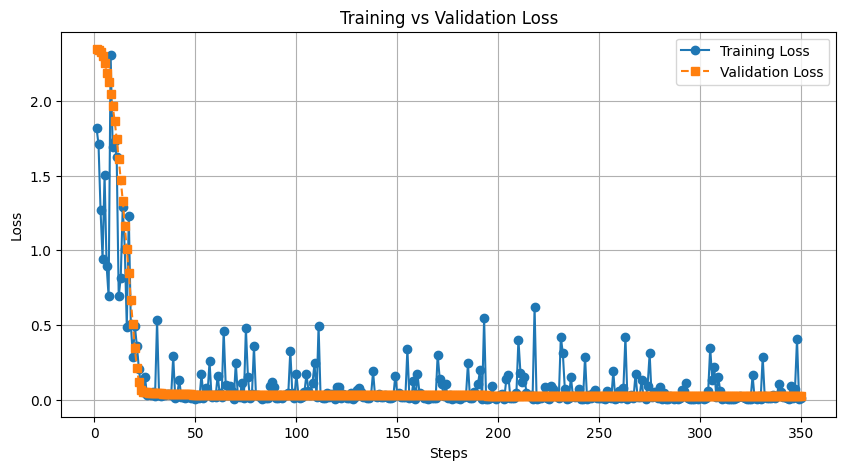

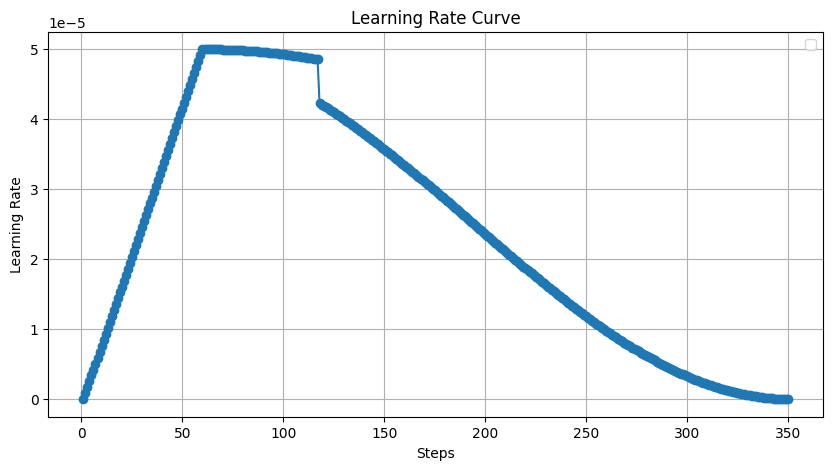

: 

In [ ]:
save_log_history(trainer)